In [ ]:
import pyam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [61]:
#pyam.iiasa.platforms()
conn = pyam.iiasa.Connection("ar6-public")
#conn.valid_connections

[INFO] 16:30:13 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 16:30:13 - pyam.iiasa: You are connected as user `bensan`


In [42]:
vars=conn.variables()

In [455]:
from IPython.display import display, HTML
import pandas as pd

search_terms = ["Sequestration"]
pattern = "(?=.*" + ")(?=.*".join(search_terms) + ")"
filtered = vars[vars.str.contains(pattern, regex=True)]

# Configure pandas to display long lines without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Display in a scrollable container
display(HTML(f"""
<div style="max-height: 300px; overflow-y: auto; overflow-x: auto; white-space: nowrap; font-family: monospace; padding: 10px; border: 1px solid #ccc;">
{filtered.to_frame().to_html(escape=False)}
</div>
"""))

,variable
247,Carbon Sequestration|CCS
248,Carbon Sequestration|CCS|Biomass
249,Carbon Sequestration|CCS|Biomass|Energy
250,Carbon Sequestration|CCS|Biomass|Energy|Demand|Industry
251,Carbon Sequestration|CCS|Biomass|Energy|Supply
252,Carbon Sequestration|CCS|Biomass|Energy|Supply|Electricity
253,Carbon Sequestration|CCS|Biomass|Energy|Supply|Gases
254,Carbon Sequestration|CCS|Biomass|Energy|Supply|Hydrogen
255,Carbon Sequestration|CCS|Biomass|Energy|Supply|Liquids
256,Carbon Sequestration|CCS|Biomass|Energy|Supply|Other


In [461]:
df = conn.query(
    variable=["Carbon Sequestration",
              "Carbon Sequestration|CCS",
              "Carbon Sequestration|Land Use", 
              "Carbon Sequestration|Direct Air Capture", 
              "Emissions|CO2", 
              "AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile",
              'Primary Energy|Oil',
              'Primary Energy|Gas',
              'Primary Energy|Coal'],
    region="World",
)

In [462]:
num_scenarios = df.data["scenario"].nunique()
print(f"Number of scenarios in df: {num_scenarios}")

Number of scenarios in df: 963


In [463]:
# Filter the dataframe using pyam's filter method for meta criteria
df = df.filter(Category=["C4", "C7", "C2", "C1", "C3", "C5", "C6"])

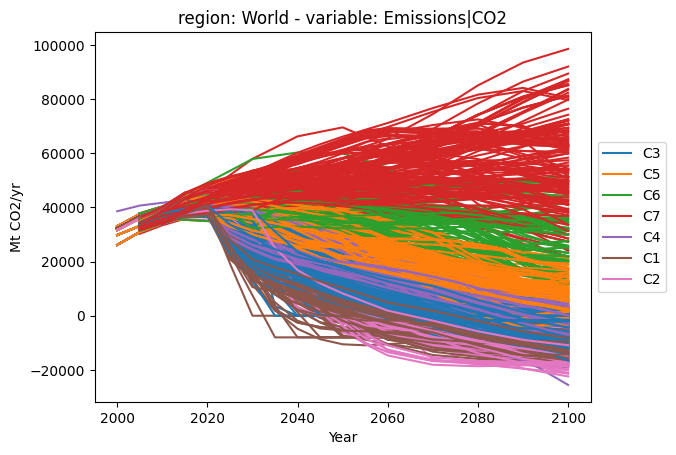

In [464]:
ax = df.filter(variable="Emissions|CO2").plot(
    color="Category", legend=dict(loc="center left", bbox_to_anchor=(1.0, 0.5))
)

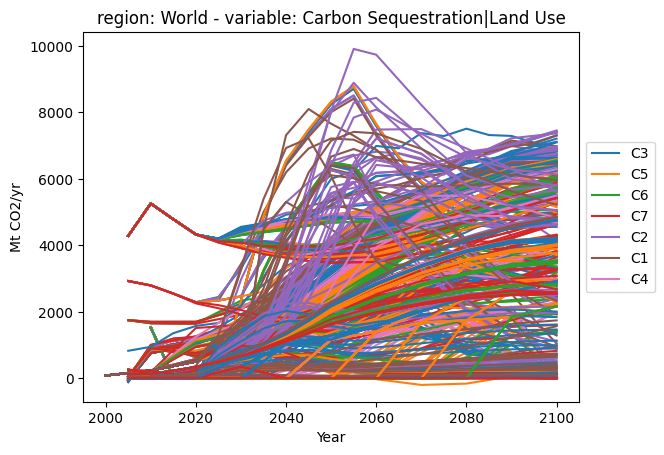

In [240]:
ax = df.filter(variable="Carbon Sequestration|Land Use").plot(
    color="Category", legend=dict(loc="center left", bbox_to_anchor=(1.0, 0.5))
)

In [241]:
def pivtab(x,catg='*'):
  tb={}
  itmp=[]
  vs=x.variable
  years=[2020,2030,2040,2050,2060,2070,2080,2090,2100]
  for vrb in vs:
    print(vrb)
    filtb=x.filter(variable=vrb,Category=catg).data
    unt=filtb.unit.unique()

    tmp=pd.pivot_table(filtb,index=['model','scenario'],columns='year',values=['value'])['value'][years].T
    unt=unt[0][:]
    tb[vrb]=tmp
    tb[vrb].unit=unt
    itmp.append(tmp.index)
  ii=tb[list(tb)[0]].index
  for ij,vrb in enumerate(vs):
    ii=ii.intersection(itmp[ij])
  for vrb in vs:
    unt=tb[vrb].unit
    tb[vrb]=tb[vrb].loc[ii]
    tb[vrb].unit=unt
    tb[vrb].name=vrb
  return tb

In [460]:
data=pivtab(df)

AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile
Carbon Sequestration|CCS
Carbon Sequestration|Direct Air Capture
Carbon Sequestration|CCS
Carbon Sequestration|Direct Air Capture
Carbon Sequestration|Land Use
Emissions|CO2
Carbon Sequestration|Land Use
Emissions|CO2
Primary Energy|Coal
Primary Energy|Gas
Primary Energy|Coal
Primary Energy|Gas
Primary Energy|Oil
Primary Energy|Oil


In [243]:
# Find the subset of columns (years) that exist in all dataframes in 'data'
common_columns = set.intersection(*(set(df.columns) for df in data.values()))


In [244]:
# Filter each dataframe in 'data' to include only columns in 'common_columns'
filtered_data = {k: v.loc[:, list(common_columns)] for k, v in data.items()}

In [459]:
# Linearly interpolate each dataframe in filtered_data to annual intervals between 2020 and 2100
annual_years = list(range(2020, 2101))
interpolated_data = {
    k: v.reindex(annual_years).interpolate(axis=0)
    for k, v in filtered_data.items()
}

In [541]:
removals=(interpolated_data['Carbon Sequestration|CCS']+
          interpolated_data['Carbon Sequestration|Land Use']+
          interpolated_data['Carbon Sequestration|Direct Air Capture']
          )/1000/44*12

In [542]:
temp=interpolated_data['AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile']

In [543]:
emissions=interpolated_data['Emissions|CO2']/1000/44*12

In [544]:
t2100 = temp.iloc[-1]

Text(0, 0.5, 'Primary Energy from Gas (EJ)')

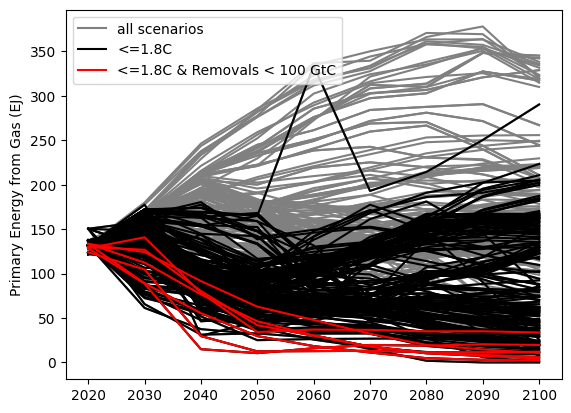

In [545]:
yrs=list(interpolated_data['Primary Energy|Gas'].index)
p1=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, :],color='grey',label='all scenarios')
p2=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, temp.columns[(temp <= 1.8).all(axis=0)]],color='black',label='<=1.8C')
p3=plt.plot(yrs,interpolated_data['Primary Energy|Gas'].loc[:, temp.columns[(temp <= 1.8).all(axis=0) & (removals.sum()<100)]],color='r',label='<=1.8C & Removals < 100 GtC')
plt.legend([p1[0],p2[0],p3[0]],['all scenarios','<=1.8C','<=1.8C & Removals < 100 GtC'])
plt.ylabel('Primary Energy from Gas (EJ)')


In [546]:
removal_bins=[0, 50, 100, 150, 200, 250, 300, 350, 400]
emission_bins=[100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100,1200]


In [547]:

# Calculate summed positive emissions and summed removals for each scenario
total_positive_emissions = (emissions).sum()
total_removals = removals.sum()

# Flatten the MultiIndex for easier handling
# Since total_positive_emissions is a Series, we use .index instead of .columns
scenario_labels = [f"{m}__{s}" for m, s in total_positive_emissions.index]

# Create a DataFrame with summed values for each scenario
classification_df = pd.DataFrame({
    'scenario': scenario_labels,
    'positive_emissions': total_positive_emissions.values,
    'removals': total_removals.values
})

# Bin the scenarios according to the provided bins
classification_df['emission_bin'] = pd.cut(classification_df['positive_emissions'], emission_bins, right=False)
classification_df['removal_bin'] = pd.cut(classification_df['removals'], removal_bins, right=False)

classification_df.head()

,scenario,positive_emissions,removals,emission_bin,removal_bin
0,REMIND-MAgPIE 2.1-4.2__EN_INDCi2030_1000f_COV_NDCp,268.392460,117.949466,"[200, 300)","[100, 150)"
1,REMIND-MAgPIE 2.1-4.2__EN_NPi2020_2500,672.312405,39.782691,"[600, 700)","[0, 50)"
2,WITCH 5.0__EN_NPi2020_1600f,389.768995,144.677030,"[300, 400)","[100, 150)"
3,WITCH 5.0__EN_NPi2020_1000f,228.172925,215.153080,"[200, 300)","[200, 250)"
4,REMIND-MAgPIE 2.1-4.2__EN_NPi2020_1000_COV,267.589934,113.181387,"[200, 300)","[100, 150)"


In [552]:
def plot_binned_variable_by_emissions_removals(variable_series, classification_df, title=None, cmap='coolwarm', xlabel='Cumulative Emissions Bin (GtC)', ylabel='Cumulative Removals Bin (GtC)', colorbar_label=None, aggregation='mean'):
    """
    Plots the mean or median value of a variable (e.g., temperature, emissions, etc.) in a 2D grid binned by cumulative emissions and removals.

    Parameters:
        variable_series (pd.Series): Series with scenario labels as index and variable values.
        classification_df (pd.DataFrame): DataFrame with 'scenario', 'emission_bin', 'removal_bin' columns.
        title (str): Plot title.
        cmap (str): Colormap for imshow.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        colorbar_label (str): Label for colorbar.
        aggregation (str): Either 'mean' or 'median' to specify how to aggregate values in each bin.
    """
    # Add variable to classification_df
    classification_df = classification_df.copy()
    temp_2100=variable_series
    temp_2100_map = {
    f"{model}__{scenario}": temp_2100[(model, scenario)]
    for model, scenario in temp_2100.index
    if (model, scenario) in temp_2100.index
    }
    classification_df['var_value'] = classification_df['scenario'].map(temp_2100_map)

    # Calculate aggregated value by bin (mean or median) and count
    grouped = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value']
    bin_counts = grouped.count()
    
    if aggregation.lower() == 'median':
        agg_var_by_bin = grouped.median()
    else:  # default to mean
        agg_var_by_bin = grouped.mean()
    
    # Set bins with fewer than 3 scenarios to NaN
    agg_var_by_bin[bin_counts < 3] = np.nan

    # Prepare grid for plotting
    emission_categories = classification_df['emission_bin'].cat.categories
    removal_categories = classification_df['removal_bin'].cat.categories
    
    # Get bin centers for proper positioning
    emission_centers = [(b.left + b.right) / 2 for b in emission_categories]
    removal_centers = [(b.left + b.right) / 2 for b in removal_categories]
    
    # Create labels showing bin ranges
    emission_bin_labels = [f"{int(b.left)}-{int(b.right)}" for b in emission_categories]
    removal_bin_labels = [f"{int(b.left)}-{int(b.right)}" for b in removal_categories]
    
    var_grid = agg_var_by_bin.unstack().T.values

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use the actual bin centers as extent for imshow
    extent = [min(emission_centers) - (emission_centers[1] - emission_centers[0])/2,
              max(emission_centers) + (emission_centers[1] - emission_centers[0])/2,
              min(removal_centers) - (removal_centers[1] - removal_centers[0])/2,
              max(removal_centers) + (removal_centers[1] - removal_centers[0])/2]
    
    im = ax.imshow(var_grid, origin='lower', aspect='auto', cmap=cmap, extent=extent)

    # Set ticks at bin centers with proper labels
    ax.set_xticks(emission_centers)
    ax.set_yticks(removal_centers)
    ax.set_xticklabels(emission_bin_labels, rotation=45, ha='right')
    ax.set_yticklabels(removal_bin_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    default_label = f'{aggregation.title()} Value' if colorbar_label is None else colorbar_label
    plt.colorbar(im, label=default_label)
    plt.tight_layout()
    return im,ax 

/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/427061420.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value']


(0.0, 500.0)

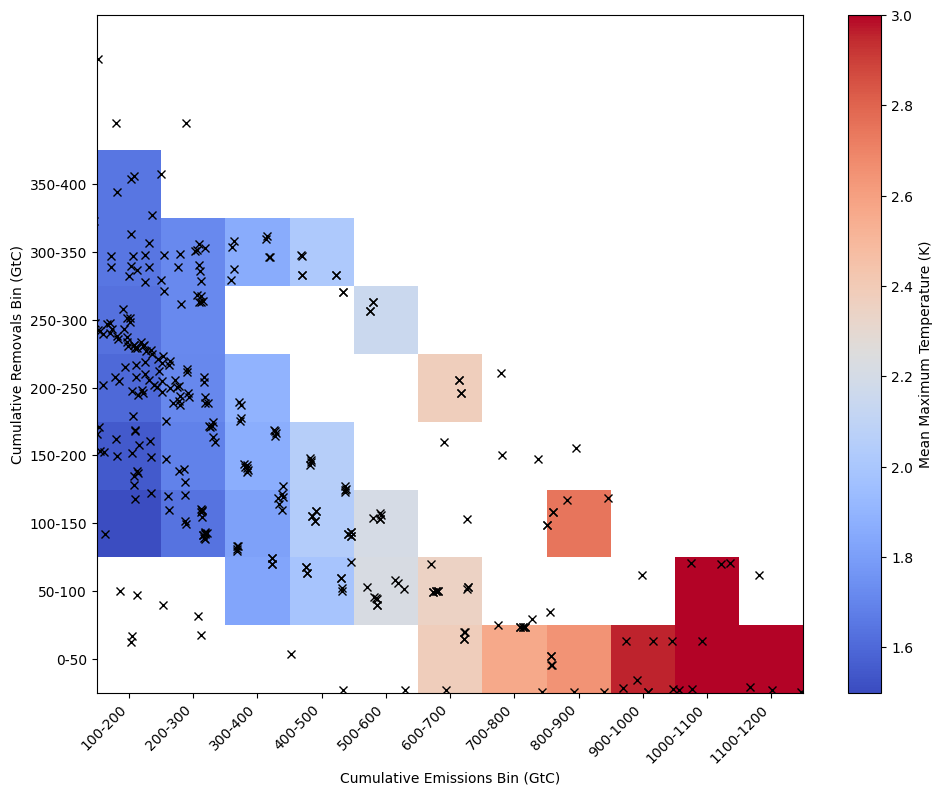

In [553]:
im,ax=plot_binned_variable_by_emissions_removals(temp.max(axis=0), classification_df,colorbar_label='Mean Maximum Temperature (K)')
im.set_clim(1.5,3)
ax.plot((emissions).sum(),removals.sum(),'kx')
ax.set_xlim(100,1200)
ax.set_ylim(0,500)


In [554]:
fossil=interpolated_data['Primary Energy|Gas']+interpolated_data['Primary Energy|Oil']+interpolated_data['Primary Energy|Coal']

/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/427061420.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value']


Text(0.5, 1.0, 'Median Fossil Energy Ratio by Emissions/Removals Bins')

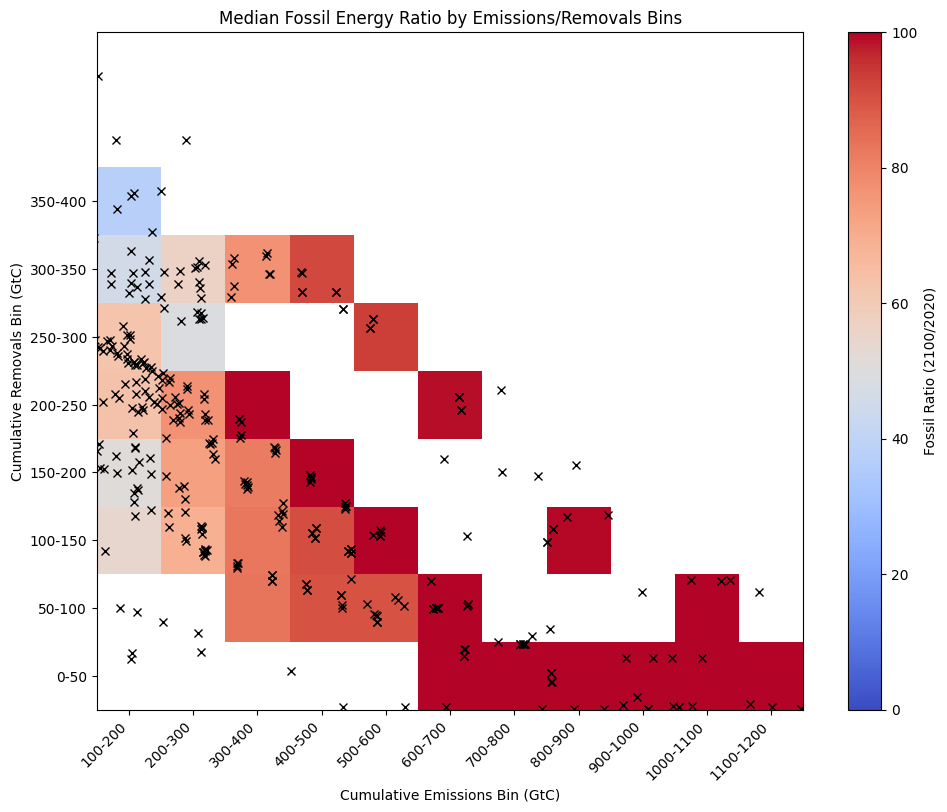

In [567]:
fracgas = fossil.loc[2040]/fossil.loc[2020]*100


im, ax = plot_binned_variable_by_emissions_removals(
    fracgas, 
    classification_df,
    colorbar_label='Fossil Ratio (2100/2020)', 
    aggregation='median'
)
im.set_clim(0, 100)
ax.plot((emissions).sum(), removals.sum(), 'kx')
ax.set_xlim(100, 1200)
ax.set_ylim(0, 500)
ax.set_title('Median Fossil Energy Ratio by Emissions/Removals Bins')

/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_59063/427061420.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = classification_df.groupby(['emission_bin', 'removal_bin'])['var_value']


Text(0.5, 1.0, 'Median Gas Energy Ratio by Emissions/Removals Bins')

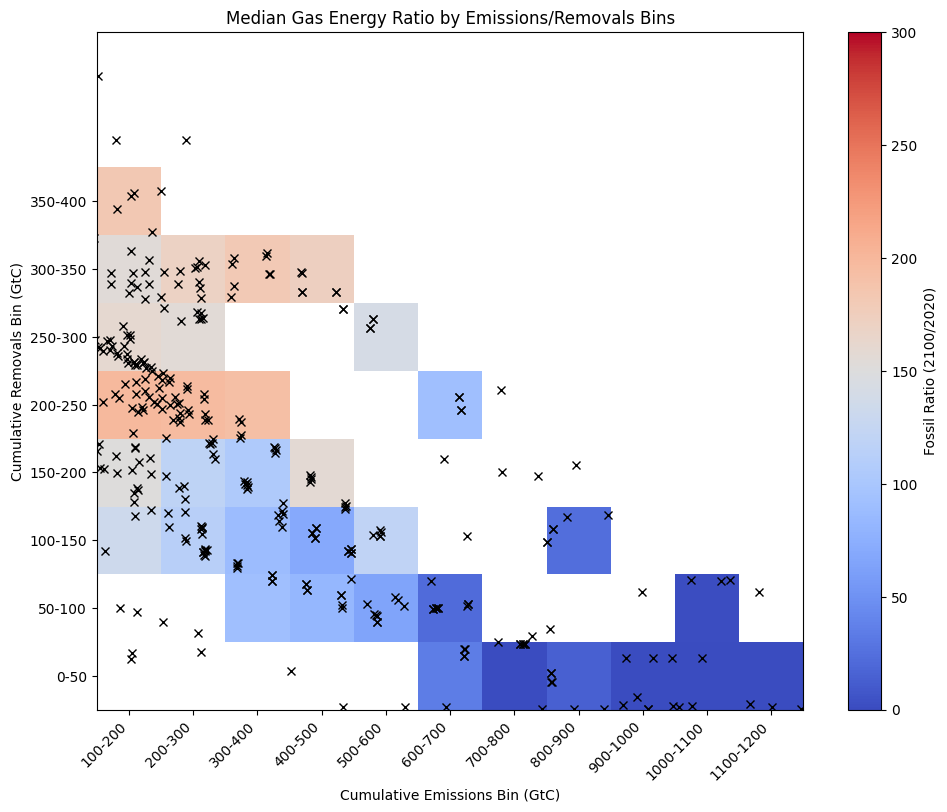

In [565]:


im, ax = plot_binned_variable_by_emissions_removals(
    interpolated_data['Carbon Sequestration|CCS'].sum()/1000*12/44, 
    classification_df,
    colorbar_label='Fossil Ratio (2100/2020)', 
    aggregation='median'
)
im.set_clim(0, 300)
ax.plot((emissions).sum(), removals.sum(), 'kx')
ax.set_xlim(100, 1200)
ax.set_ylim(0, 500)
ax.set_title('Median Gas Energy Ratio by Emissions/Removals Bins')